In [6]:
import os
import csv

samples = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
samples.remove(samples[0])

print("Training samples count is "+ str(len(samples)))


Training samples count is 5071


In [7]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
from sklearn.utils import shuffle

import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = 'data/IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                
                name = 'data/IMG/'+batch_sample[1].split('/')[-1]
                left_image = cv2.imread(name)
                images.append(left_image)
                angles.append(center_angle+0.2)
                
                name = 'data/IMG/'+batch_sample[2].split('/')[-1]
                right_image = cv2.imread(name)
                images.append(right_image)
                angles.append(center_angle-0.2)

            augmented_images = []
            augmented_angles = []

            #Augment the images by flipping the images and negating the angle.
            for image, angle in zip(images, angles):
                augmented_images.append(image)
                augmented_angles.append(angle)
                augmented_images.append(np.fliplr(image))
                augmented_angles.append(angle*-1)   
            
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [8]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Convolution2D, MaxPooling2D,Cropping2D, Dropout

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples)*6, validation_data = 
    validation_generator,
    nb_val_samples = len(validation_samples)*6, 
    nb_epoch=5, verbose=1)



Epoch 1/5
24336/24336 [==============================] - 50s - loss: 0.0633 - val_loss: 0.0658
Epoch 2/5
24336/24336 [==============================] - 48s - loss: 0.0553 - val_loss: 0.0582
Epoch 3/5
24336/24336 [==============================] - 48s - loss: 0.0519 - val_loss: 0.0548
Epoch 4/5
24336/24336 [==============================] - 48s - loss: 0.0497 - val_loss: 0.0553
Epoch 5/5
24336/24336 [==============================] - 48s - loss: 0.0479 - val_loss: 0.0529


dict_keys(['val_loss', 'loss'])


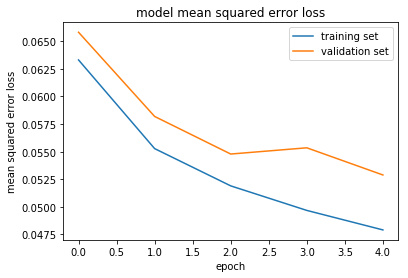

In [10]:
import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
model.save('model.h5')